### Offensive Language Identification

ERNIE 2.0 is a continual pre-training framework proposed by Baidu in 2019, which builds and learns incrementally pre-training tasks through constant multi-task learning.
This project will convert ERNIE to huggingface's format.

### Set up

In [1]:
pip install paddlepaddle

     |████████████████████████████████| 168.5MB 27kB/s 


In [2]:
pip install paddle-ernie

  Created wheel for paddle-ernie: filename=paddle_ernie-0.1.0.dev1-cp37-none-any.whl size=20016 sha256=d1a5c481e188f8bab149866781500ac5b1e5b929bf01376828ad767cc999c0ee
  Stored in directory: /root/.cache/pip/wheels/ef/d8/52/d0fc0e19bce14963259ada61138e6c520805bd688e29652796
Successfully built paddle-ernie


In [3]:
pip install --upgrade paddlenlp>=2.0.0rc -i https://pypi.org/simple

In [4]:
pip install sentencepiece

     |████████████████████████████████| 1.2MB 9.4MB/s 


In [5]:
pip install transformers

     |████████████████████████████████| 2.1MB 8.1MB/s 
     |████████████████████████████████| 901kB 35.4MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 


In [6]:
import torch
import paddle
import paddlenlp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textwrap import wrap
from torch import nn, optim
from collections import defaultdict
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

from ernie.modeling_ernie import ErnieModel
from ernie.tokenizing_ernie import ErnieTokenizer
from ernie.modeling_ernie import ErnieModelForSequenceClassification

/usr/local/lib/python3.7/dist-packages/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


In [7]:
# Load pre-trained ERNIE 2.0 model and ERNIE tokenizer.

tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-en")

model = AutoModel.from_pretrained("nghuyong/ernie-2.0-en", return_dict=False)

2021-04-28 03:37:48,338 - INFO - Lock 140418959259664 acquired on /root/.cache/huggingface/transformers/22d34926689d46e875370d2df90e2b40c9e2f6a754003f3e4f520890ed4b2941.348bf454a4de5dea8471d837bcfb348dc42bca3b7b27f2e07fc244be6ad85f1f.lock


2021-04-28 03:37:48,600 - INFO - Lock 140418959259664 released on /root/.cache/huggingface/transformers/22d34926689d46e875370d2df90e2b40c9e2f6a754003f3e4f520890ed4b2941.348bf454a4de5dea8471d837bcfb348dc42bca3b7b27f2e07fc244be6ad85f1f.lock


2021-04-28 03:37:48,812 - INFO - Lock 140418933378640 acquired on /root/.cache/huggingface/transformers/1ab10693e539d85024e9dfd259048b22e64a07e891b6d867a080b79b40db1b62.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


2021-04-28 03:37:49,287 - INFO - Lock 140418933378640 released on /root/.cache/huggingface/transformers/1ab10693e539d85024e9dfd259048b22e64a07e891b6d867a080b79b40db1b62.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


2021-04-28 03:37:50,067 - INFO - Lock 140421761209104 acquired on /root/.cache/huggingface/transformers/33f8794015698a2d68c128ff2ccc8bf54d1faebb956adf949a3be00ad6496115.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


2021-04-28 03:37:50,320 - INFO - Lock 140421761209104 released on /root/.cache/huggingface/transformers/33f8794015698a2d68c128ff2ccc8bf54d1faebb956adf949a3be00ad6496115.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


2021-04-28 03:37:50,529 - INFO - Lock 140418933426576 acquired on /root/.cache/huggingface/transformers/adffd3dc92cda16f89403840540d8a26fa86a68be8074087fd0b808d71bc9a7a.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29.lock


2021-04-28 03:37:50,787 - INFO - Lock 140418933426576 released on /root/.cache/huggingface/transformers/adffd3dc92cda16f89403840540d8a26fa86a68be8074087fd0b808d71bc9a7a.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29.lock


2021-04-28 03:37:51,275 - INFO - Lock 140418933378384 acquired on /root/.cache/huggingface/transformers/e4590b8215d335899d48d7b5d9a080f33663a611731a758597836bb837c70a3c.67e876ab5ebe858ae9e766f73e37366bab7f513423a551f2b220bbbabe79a026.lock


2021-04-28 03:38:07,811 - INFO - Lock 140418933378384 released on /root/.cache/huggingface/transformers/e4590b8215d335899d48d7b5d9a080f33663a611731a758597836bb837c70a3c.67e876ab5ebe858ae9e766f73e37366bab7f513423a551f2b220bbbabe79a026.lock


### Data Exploration

We will load the irony dataset from TweetEval to evaluate ERNIE 2.0 model. The irony dataset has already been split into training set, tuning set and test set.

In [8]:
df_train_text = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/tweeteval/main/datasets/offensive/train_text.txt", delimiter="\t", names=["Tweet"])

In [9]:
df_train_label = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/tweeteval/main/datasets/offensive/train_labels.txt", delimiter="\t", names=["Label"])

In [10]:
df_train = df_train_text.join(df_train_label)
df_train.to_csv("train.csv", encoding='utf-8', index=False)
df_train

,Tweet,Label
0,@user Bono... who cares. Soon people will unde...,0
1,@user Eight years the republicans denied obama...,1
2,@user Get him some line help. He is gonna be j...,0
3,@user @user She is great. Hi Fiona!,0
4,@user She has become a parody unto herself? Sh...,1
...,...,...
11911,@user I wonder if they are sex traffic victims?,1
11912,@user Do we dare say he is... better than Nyjer?,0
11913,@user No idea who he is. Sorry,0
11914,#Professor Who Shot Self Over Trump Says Gun C...,0


In [11]:
df_val_text = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/tweeteval/main/datasets/offensive/val_text.txt", delimiter="\t", names=["Tweet"])

In [12]:
df_val_label = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/tweeteval/main/datasets/offensive/val_labels.txt", delimiter="\t", names=["Label"])

In [13]:
df_val = df_val_text.join(df_val_label)
df_val.to_csv("val.csv", encoding='utf-8', index=False)
df_val

,Tweet,Label
0,@user @user WiiU is not even a real console.,0
1,@user @user @user If he is from AZ I would put...,1
2,@user I thought Canada had strict gun control....,0
3,@user @user @user @user @user @user @user @use...,0
4,1 Minute of Truth: Gun Control via @user,0
...,...,...
1319,@user @user Whose twitter interest start with ...,0
1320,"@user @user How did the press"""" get the letter...",0
1321,@user @user @user @user @user @user Sorry abou...,0
1322,@user Fuck Alan I’m sorry,1


In [14]:
df_test_text = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/tweeteval/main/datasets/offensive/test_text.txt", delimiter="\t", names=["Tweet"])

In [15]:
df_test_label = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/tweeteval/main/datasets/offensive/test_labels.txt", delimiter="\t", names=["Label"])

In [16]:
df_test = df_test_text.join(df_test_label)
df_test.to_csv("test.csv", encoding='utf-8', index=False)
df_test

,Tweet,Label
0,#ibelieveblaseyford is liar she is fat ugly li...,1
1,@user @user @user I got in a pretty deep debat...,0
2,"...if you want more shootings and more death, ...",0
3,Angels now have 6 runs. Five of them have come...,0
4,#Travel #Movies and Unix #Fortune combined Vi...,0
...,...,...
855,#CNN irrationally argues 4 legalising #abortio...,0
856,@user @user @user @user @user @user @user @use...,0
857,#Conservatives don’t care what you post..it’s ...,1
858,#antifa #Resist.. Trump is trying to bring wor...,0


In [17]:
df_train.shape, df_val.shape, df_test.shape

((11916, 2), (1324, 2), (860, 2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label class')

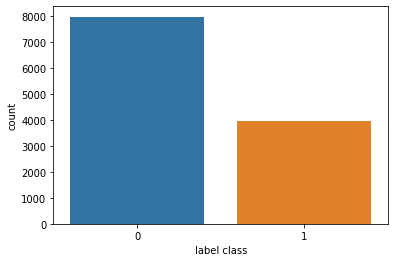

In [18]:
# Training set

sns.countplot(df_train['Label'])
plt.xlabel('label class')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label class')

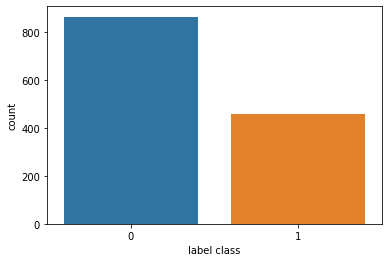

In [19]:
# Validation set

sns.countplot(df_val['Label'])
plt.xlabel('label class')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label class')

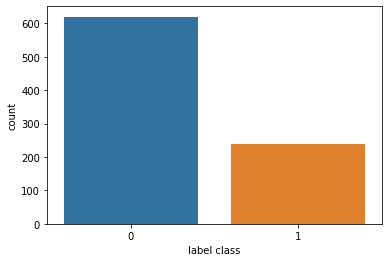

In [20]:
# Test set

sns.countplot(df_test['Label'])
plt.xlabel('label class')

### Data Preprocessing

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

In [21]:
# Use this sample text from training set to understand the tokenization process:

sample_text = df_train['Tweet'][0]

In [22]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True, # Add '[PAD]'
  return_attention_mask=True,
  return_tensors='pt', # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [23]:
# Inverse the tokenization to have a look at the special tokens:

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '@',
 'user',
 'bono',
 '.',
 '.',
 '.',
 'who',
 'cares',
 '.',
 'soon',
 'people',
 'will',
 'understand',
 'that',
 'they',
 'gain',
 'nothing',
 'from',
 'following',
 'a',
 'ph',
 '##ony',
 'celebrity',
 '.',
 'become',
 'a',
 'leader',
 'of',
 'your',
 'people',
 'instead',
 'or',
 'help',
 'and',
 'support',
 'your',
 'fellow',
 'country',
 '##men',
 '.',
 '[SEP]']

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

42


tensor([  101,  1030,  5310, 23648,  1012,  1012,  1012,  2040, 14977,  1012,
         2574,  2111,  2097,  3305,  2008,  2027,  5114,  2498,  2013,  2206,
         1037,  6887, 16585,  8958,  1012,  2468,  1037,  3003,  1997,  2115,
         2111,  2612,  2030,  2393,  1998,  2490,  2115,  3507,  2406,  3549,
         1012,   102])

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

42


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

### Choosing Sequence Length

In [26]:
# Store the token length of each tweet:

token_lens = []

for tweet in df_train['Tweet']:
  tokens = tokenizer.encode(tweet)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


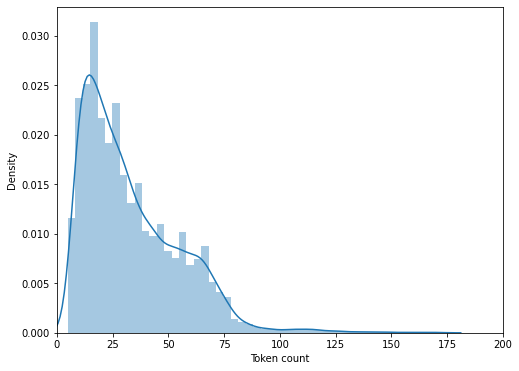

In [27]:
# Plot the distribution:

plt.figure(figsize=(8, 6))
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [28]:
# Most of the tweet seem to contain less than 60 tokens, but we'll be on the safe side and choose a maximum length of 64.

MAX_LEN = 128

In [29]:
# Create a PyTorch dataset:

class TweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [30]:
# Create data loader function:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweetDataset(
    tweets=df['Tweet'].to_numpy(),
    targets=df['Label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [31]:
# Choose a proper batch size and apply the data loader function to training data, validation data and test data:

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
# Have a look at an example batch from our training data loader:

data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [33]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


### Sentiment Classification with ERNIE 2.0 and Hugging Face

In [34]:
# The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the ERNIE Pooler on last_hidden_state:

last_hidden_state, pooled_output = model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [35]:
last_hidden_state.shape

torch.Size([1, 42, 768])

In [36]:
model.config.hidden_size

768

In [37]:
pooled_output.shape

torch.Size([1, 768])

In [39]:
# We use all of the previous knowledge to create a sentiment classifier that uses ERNIE 2.0 model:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.ernie = AutoModel.from_pretrained("nghuyong/ernie-2.0-en", return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.ernie.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.ernie(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
class_names = ['not-offensive', 'offensive']

In [42]:
# Create an instance and move it to the Colab GPU:

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [43]:
# Move the example batch of our training data to the Colab GPU:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [44]:
model(input_ids, attention_mask)

tensor([[-0.1647,  0.3215],
        [ 0.4343,  0.3459],
        [ 0.0238, -0.4144],
        [-0.1698, -0.1869],
        [-0.2536, -0.2827],
        [-0.1187, -0.1317],
        [-0.6639,  0.3726],
        [-0.1381,  0.2858],
        [-0.1741, -0.2641],
        [ 0.5825, -0.3806],
        [ 0.2252,  0.0172],
        [-0.2510,  0.1399],
        [ 0.3558, -0.1499],
        [-0.0619, -0.0396],
        [-0.5224,  0.0171],
        [ 0.1511, -0.1203]], device='cuda:0', grad_fn=<AddmmBackward>)

### Model training
 
Although our datasets are small, we set the hyperparameters (batch size, learning rate and number of epoch) at reasonable values in order to avoid over-fitting and to obtain high prediction accuracy. We use the AdamW optimizer provided by Hugging Face that could correct weight decay. We also use a linear scheduler with no warmup steps.

- Optimizer: AdamW
- Batch size: 16
- Learning rate : 2e-5
- Number of epochs: 10

In [45]:
# Set up epochs, optimizer and scheduler:

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [46]:
# A helper function for training our model for one epoch:

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
# Another helper function that helps us evaluate the model on a given data loader:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
# Using those two helper functions, we can write our training loop. We'll also store the training history:

%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a

Train loss 0.5032237859780356 accuracy 0.772322927156764


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val   loss 0.44188795391335545 accuracy 0.7885196374622356

Epoch 2/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.4221098029873515 accuracy 0.8290533736153072


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.4863216850053833 accuracy 0.7847432024169184

Epoch 3/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Train loss 0.3702244436480855 accuracy 0.8627895266868076


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val   loss 0.5238068163035864 accuracy 0.7900302114803626

Epoch 4/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.3336987562177565 accuracy 0.8908190668009399


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.6151942997632256 accuracy 0.7885196374622356

Epoch 5/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.31870653548796707 accuracy 0.9033232628398792


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Val   loss 0.6062508690429022 accuracy 0.7960725075528701

Epoch 6/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.29646864418915453 accuracy 0.9131419939577039


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.651895370603685 accuracy 0.7892749244712991

Epoch 7/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.27130534912165777 accuracy 0.9241356159785162


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.6804373671401696 accuracy 0.7922960725075529

Epoch 8/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Train loss 0.24958852243753488 accuracy 0.9328633769721383


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.7007317466728659 accuracy 0.790785498489426

Epoch 9/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.2399939482844116 accuracy 0.9376468613628735


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.7266255717006433 accuracy 0.7885196374622356

Epoch 10/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.23024503500169555 accuracy 0.9405840886203424


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.7157046080578163 accuracy 0.7968277945619335

CPU times: user 27min 22s, sys: 21min 24s, total: 48min 47s
Wall time: 49min 1s


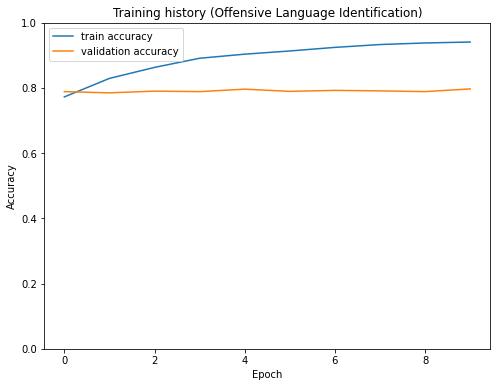

In [58]:
# Plot the training accuracy and validation accuracy of each epoch:

plt.figure(figsize=(8, 6))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history (Offensive Language Identification)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

Calculating the accuracy on our test set:

In [50]:
# Calculating the accuracy on the test set:

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

0.8348837209302326

In [51]:
# Define a helper function to get the predictions from our model:

def get_predictions(model, data_loader):
  model = model.eval()
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [52]:
# Storing the text of tweets and predicted probabilities:

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

In [53]:
# Print the classification report:

print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not-offensive       0.86      0.92      0.89       620
    offensive       0.74      0.62      0.68       240

     accuracy                           0.83       860
    macro avg       0.80      0.77      0.78       860
 weighted avg       0.83      0.83      0.83       860



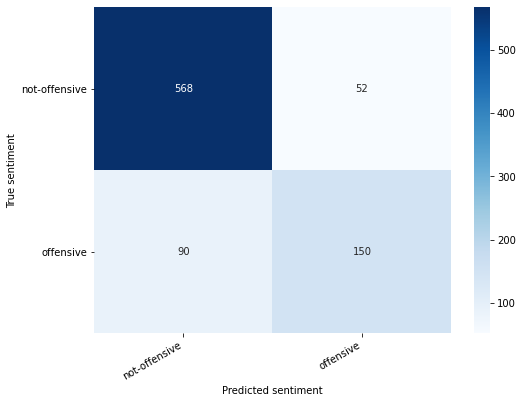

In [60]:
# Plot the confusion matrix:

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [55]:
# Check an example tweet from the test set:

idx = 2
tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [56]:
print("\n".join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

...if you want more shootings and more death, then listen to the ACLU,
Black Lives Matter, or Antifa. If you want public safety, then listen
to the police professionals who have been studying this for 35
years."" -AG Jeff Sessions

True sentiment: not-offensive


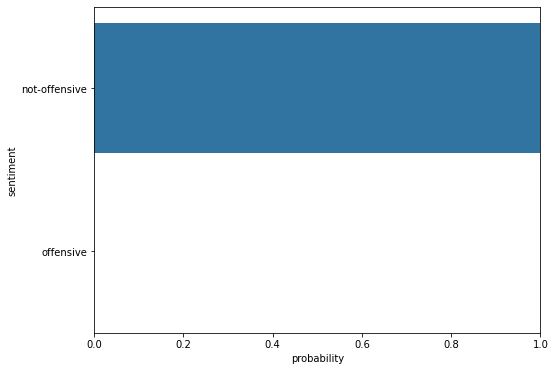

In [57]:
# Look at the confidence of each sentiment of our model:

plt.figure(figsize=(8, 6))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);